# Classification Using LSTM

In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
df = pd.read_csv('drive/My Drive/waterDataTraining.csv')

In [18]:
def data_preprocessing(df):
    df['Time'] = pd.to_datetime(df['Time'])
    df.set_index('Time', inplace=True)

    df.drop(columns=['Tp', 'Fm', 'Fm_2'], inplace=True)

    df.interpolate(method='time', inplace=True)

    scaler = MinMaxScaler()
    df[df.columns] = scaler.fit_transform(df[df.columns])

    return df

data = data_preprocessing(df)

In [19]:
def create_sequences(data, column_name, sequence_length):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data.iloc[i: i + sequence_length].drop(columns=['column_name']).values)
        labels.append(data.iloc[i + sequence_length]['column_name'])
    return np.array(sequences), np.array(labels)


sequence_length = 10
sequences, labels = create_sequences(data, "EVENT", sequence_length)

X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.2, random_state=42)

In [20]:
model = Sequential([
    LSTM(50, activation='relu', input_shape=(sequence_length, X_train.shape[2]), return_sequences=True),
    Dropout(0.5),
    LSTM(50, activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 10, 50)            11400     
                                                                 
 dropout_4 (Dropout)         (None, 10, 50)            0         
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 31651 (123.64 KB)
Trainable params: 31651 (123.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
2792/2792 [==============================] - 48s 15ms/step - loss: 0.0744 - accuracy: 0.9886 - val_loss: 0.0700 - val_accuracy: 0.9864
Epoch 2/10
2792/2792 [==============================] - 43s 16ms/step - loss: 0.0616 - accuracy: 0.9886 - val_loss: 0.0557 - val_accuracy: 0.9897
Epoch 3/10
2792/2792 [==============================] - 43s 15ms/step - loss: 0.0563 - accuracy: 0.9898 - val_loss: 0.0590 - val_accuracy: 0.9899
Epoch 4/10
2792/2792 [==============================] - 45s 16ms/step - loss: 0.0517 - accuracy: 0.9905 - val_loss: 0.0654 - val_accuracy: 0.9891
Epoch 5/10
2792/2792 [==============================] - 44s 16ms/step - loss: 0.0511 - accuracy: 0.9907 - val_loss: 0.0459 - val_accuracy: 0.9905
Epoch 6/10
2792/2792 [==============================] - 43s 15ms/step - loss: 0.0493 - accuracy: 0.9908 - val_loss: 0.0452 - val_accuracy: 0.9900
Epoch 7/10
2792/2792 [==============================] - 54s 19ms/step - loss: 0.0472 - accuracy: 0.9906 - val_loss: 0.0534 -

873/873 [==============================] - 4s 4ms/step
Confusion Matrix:
[[27523    53]
 [  176   160]]
Precision: 0.7512
Recall: 0.4762
F1-Score: 0.5829


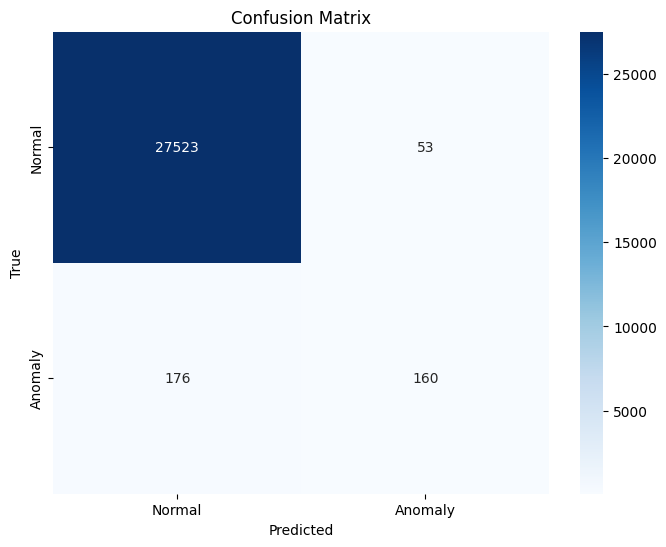

In [22]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

y_pred = (model.predict(X_test) > 0.5).astype("int32")
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Confusion Matrix:\n{cm}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

def plot_confusion_matrix(cm, class_names):
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=ax)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(cm, class_names=['Normal', 'Anomaly'])

In [23]:
sequences_all, _ = create_sequences(df, sequence_length)
anomalies_all = (model.predict(sequences_all) > 0.5).astype("int32")

data['LSTM_Anomaly'] = False

data.iloc[sequence_length:, data.columns.get_loc('LSTM_Anomaly')] = anomalies_all.flatten()

4362/4362 [==============================] - 21s 5ms/step


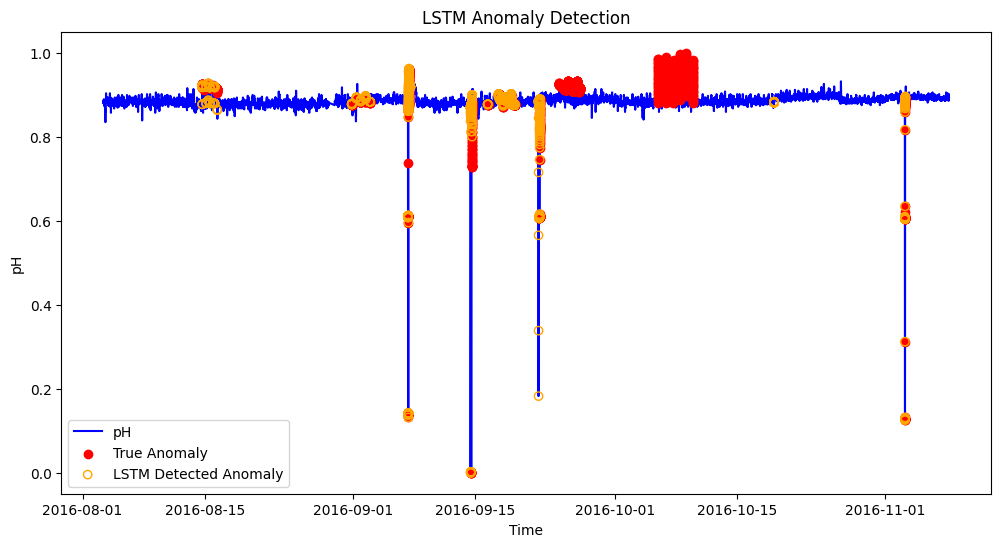

In [28]:
def plot_anomalies(df):
    df['EVENT'] = df['EVENT'].astype(bool)
    df['LSTM_Anomaly'] = df['LSTM_Anomaly'].astype(bool)

    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['pH'], label='pH', color='blue')
    plt.scatter(df.index[df['EVENT']], df['pH'][df['EVENT']], color='red', label='True Anomaly', zorder=5)
    plt.scatter(df.index[df['LSTM_Anomaly']], df['pH'][df['LSTM_Anomaly']], facecolors='none', edgecolors='orange', label='LSTM Detected Anomaly', zorder=6)
    plt.legend()
    plt.title('LSTM Anomaly Detection')
    plt.xlabel('Time')
    plt.ylabel('pH')
    plt.show()

plot_anomalies(data)

In [25]:
def plot_results(history):
    hist_df = pd.DataFrame(history.history)
    hist_df.columns=["loss", "accuracy", "val_loss", "val_accuracy"]
    hist_df.index = np.arange(1, len(hist_df)+1)

    fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(16, 10))
    axs[0].plot(hist_df.val_accuracy, lw=3, label='Validation Accuracy')
    axs[0].plot(hist_df.accuracy, lw=3, label='Training Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].grid()
    axs[0].legend(loc=0)
    axs[1].plot(hist_df.val_loss, lw=3, label='Validation Loss')
    axs[1].plot(hist_df.loss, lw=3, label='Training Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].grid()
    axs[1].legend(loc=0)

    plt.show();

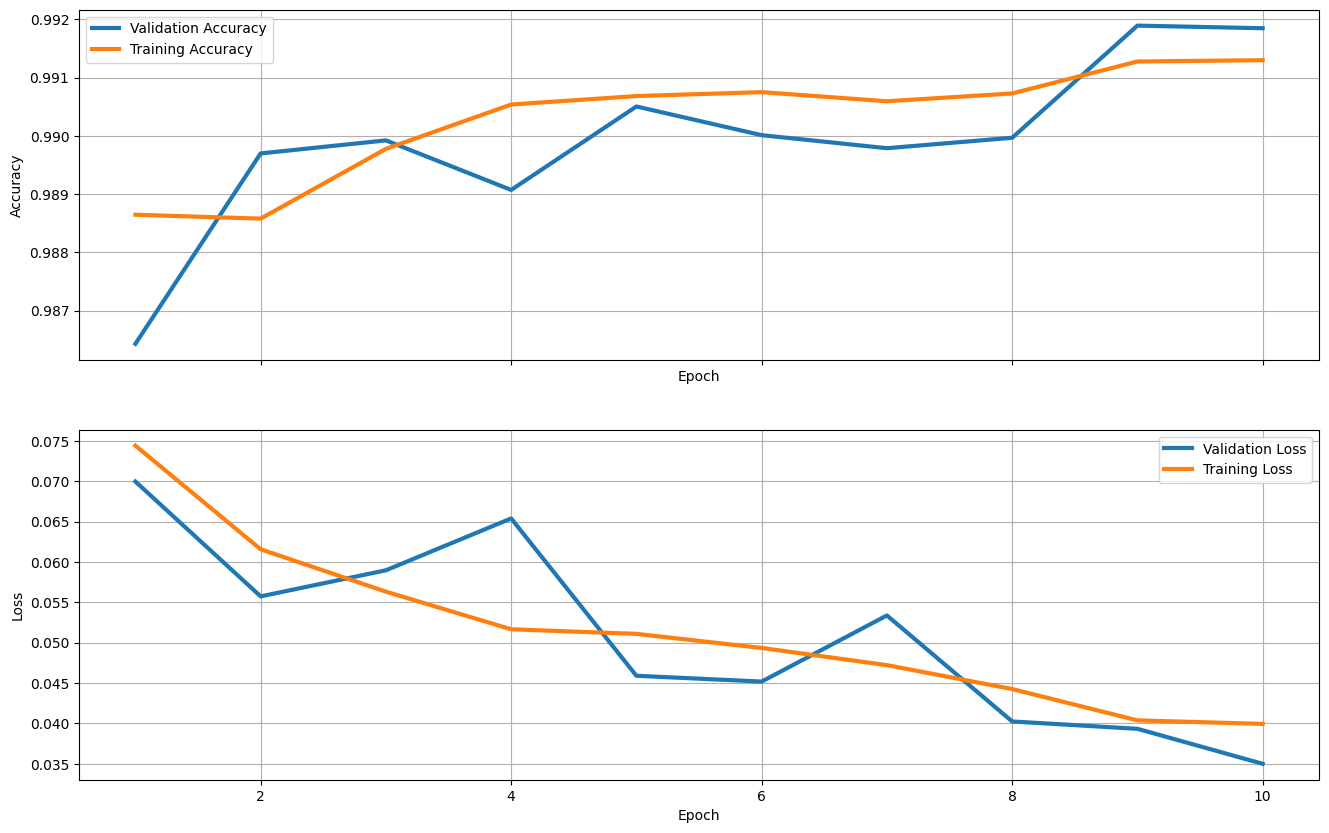

In [26]:
plot_results(history)